In [3]:
from mysql.connector import connect, errorcode, Error, pooling
from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor, as_completed
from os import environ
from fastavro import writer, parse_schema
import pandas as pd
from dotenv import load_dotenv
from queue import Queue
import time
import math
import threading
import os

load_dotenv()

True

In [4]:
config = {
    "user": environ['DATABASE_USERNAME'],
    "password": environ['DATABASE_PASSWORD'],
    "host": environ['DATABASE_HOST'],
    "database": environ['DATABASE_NAME'],
    "charset": 'utf8'
}

In [9]:
def get_connection():
    try:
        print("Connecting to the database...\n config: ", config)
        return connect(**config)
    except Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
        return None
    
def get_data(connection: connect, query: str):
    my_cursor = connection.cursor()
    my_cursor.execute(query)
    data = my_cursor.fetchall()
    my_cursor.close()
    return data
    

def export_to_avro(data, columns, filename):
    # Definición del esquema AVRO con todos los campos como cadenas
    schema = {
        "doc": "Ventas record",
        "name": "Venta",
        "namespace": "un.database",
        "type": "record",
        "fields": [{"name": col, "type": "string"} for col in columns]
    }

    parsed_schema = parse_schema(schema)

    # Convertir cada fila a un diccionario con los nombres de columnas como claves
    records = [dict(zip(columns, map(str, row))) for row in data]

    # Escribir el archivo AVRO
    with open(filename, 'wb') as out_file:
        writer(out_file, parsed_schema, records)

In [6]:
#Obtención de datos de la base de datos indicando el inicio de la extracción y la cantidad de datos a obtener. Esto es lo que hará cada hilo
def get_data_batch(offset, limit, queue):
    cnx = get_connection()
    if not cnx:
        return
    cursor = cnx.cursor()
    query = f"SELECT * FROM UN.VENTAS LIMIT {limit} OFFSET {offset}"
    cursor.execute(query)
    data = cursor.fetchall()
    queue.put(data)
    cursor.close()
    cnx.close()
       
def extract_all_data_parallel(batch_size, num_threads):
    # Paso 1: Obtener el total de registros de la tabla
    cnx = get_connection()
    cursor = cnx.cursor()
    cursor.execute("SELECT COUNT(*) FROM UN.VENTAS")
    total_rows = cursor.fetchone()[0]
    cursor.close()
    cnx.close()

    # Paso 2: Calcular desde dónde debe empezar cada lote de datos
    offsets = []
    current_offset = 0
    while current_offset < total_rows:
        offsets.append(current_offset)
        current_offset += batch_size

    all_data = []

    # Paso 3: Crear un grupo de hilos (máximo num_threads a la vez)
    print(f"Enviando {len(offsets)} tareas al pool")
    inicio = time.time()
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        for offset in offsets:
            print(f"Lanzando tarea con OFFSET {offset}")
            future = executor.submit(get_data_batch_direct, offset, batch_size)
            futures.append(future)

        for future in as_completed(futures):
            result = future.result()
            all_data.extend(result)
    print(f"Extracción con hilos tomó: {time.time() - inicio:.2f} segundos")

    # Paso 6: Retornar todos los datos extraídos
    return all_data

def get_data_batch_direct(offset, limit):
    cnx = None
    try:
        cnx = get_connection()
        cursor = cnx.cursor()
        cursor.execute(f"SELECT * FROM UN.VENTAS LIMIT {limit} OFFSET {offset}")
        data = cursor.fetchall()
        cursor.close()
        return data
    finally:
        if cnx:
            cnx.close()

In [ ]:
import dask
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import time
import mysql.connector
dask.config.set(scheduler='threads', num_workers=5)
# Total de filas
def get_total_rows():
    cnx = get_connection()
    cursor = cnx.cursor()
    cursor.execute("SELECT COUNT(*) FROM UN.VENTAS")
    total = cursor.fetchone()[0]
    cursor.close()
    cnx.close()
    return total

# Tarea diferida
@delayed
def get_data_batch(offset, limit):
    cnx = get_connection()
    cursor = cnx.cursor()
    cursor.execute(f"SELECT * FROM UN.VENTAS LIMIT {limit} OFFSET {offset}")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    cnx.close()
    return pd.DataFrame(data, columns=columns)

# Extracción principal
def extract_all_data_dask(batch_size):
    total_rows = get_total_rows()
    offsets = list(range(0, total_rows, batch_size))  # solo 5 si batch_size=200_000
    
    print(f"Lanzando {len(offsets)} tareas con Dask")
    inicio = time.time()

    tasks = [get_data_batch(offset, batch_size) for offset in offsets]
    result_dfs = dask.compute(*tasks)  # Ejecuta en paralelo

    final_df = pd.concat(result_dfs, ignore_index=True)

    print(f"Extracción con Dask tomó: {time.time() - inicio:.2f} segundos")
    return final_df

# Lanzamiento
df = extract_all_data_dask(batch_size=200_000)
print(df.head())

In [ ]:
# Exportar y medir el tiempo para cada formato
def measure_export_times(df, max_n):
    export_times = {
        "CSV": [],
        "JSON": [],
        "Parquet": [],
        "Avro": []  # Placeholder, Avro requiere implementación con fastavro o avro-python3
    }

    for n in range(1, max_n + 1):
        sample = df.iloc[:n]

        # CSV
        start = time.time()
        sample.to_csv("temp.csv", index=False)
        export_times["CSV"].append((n, time.time() - start))

        # JSON
        start = time.time()
        sample.to_json("temp.json", orient="records", lines=True)
        export_times["JSON"].append((n, time.time() - start))

        # Parquet
        start = time.time()
        sample.to_parquet("temp.parquet")
        export_times["Parquet"].append((n, time.time() - start))

        # Avro (opcional: debes implementar si deseas usarlo)

    return export_times

In [ ]:
print("Extrayendo datos...")
inicio = time.time()
data = extract_all_data_parallel(200000, 5)
print(time.time() - inicio)


print(f"Total de registros extraídos: {len(data)}")

columns = ['ID_VENTA', 'FECHA_VENTA', 'ID_CLIENTE', 'ID_EMPLEADO',
            'ID_PRODUCTO', 'CANTIDAD', 'PRECIO_UNITARIO', 'DESCUENTO', 'FORMA_PAGO']

df = pd.DataFrame(data, columns=['ID_VENTA', 'FECHA_VENTA', 'ID_CLIENTE', 'ID_EMPLEADO',
                  'ID_PRODUCTO', 'CANTIDAD', 'PRECIO_UNITARIO', 'DESCUENTO', 'FORMA_PAGO'])

df

"""print("Midiendo tiempos de exportación...")

#export_results = measure_export_times(df, max_n=10000)  # o hasta 1_000_000 según tu capacidad

print("Exportación terminada.")



for fmt, times in export_results.items():
    print(f"\nFormato: {fmt}")
    for n, t in times[:5]:  # muestra solo los primeros 5 para verificar
        print(f"{n} registros: {t:.4f} s")
"""


In [ ]:
def get_connection1():
    try:
        print("Connecting to the database...\n config: ", config)
        return connect(**config)
    except Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
        return None
    
cnx = get_connection1()

print("Connection established")

data = get_data(cnx, "SELECT * FROM UN.VENTAS LIMIT 10")


df = pd.DataFrame(data, columns=['ID_VENTA', 'FECHA_VENTA', 'ID_CLIENTE', 'ID_EMPLEADO',
                  'ID_PRODUCTO', 'CANTIDAD', 'PRECIO_UNITARIO', 'DESCUENTO', 'FORMA_PAGO'])

cnx.close()

df


Connecting to the database...
 config:  {'user': 'ed2studentsG6', 'password': 'd8d0274ccb39fcded4a5fac1961580104770fa93620f4a699cccecae58e8efe5', 'host': 'lab-ed.c9q48as80ych.us-east-1.rds.amazonaws.com', 'database': 'UN', 'charset': 'utf8'}
Connection established


,ID_VENTA,FECHA_VENTA,ID_CLIENTE,ID_EMPLEADO,ID_PRODUCTO,CANTIDAD,PRECIO_UNITARIO,DESCUENTO,FORMA_PAGO
0,00004df7-75ba-4693-b8a8-e7157fca6b35,2024-08-09,5476,810,1178,13,666.58,20.75,Transfer
1,00006952-8e9e-4f4a-871b-0c8a905d837c,2024-08-10,942,730,1577,16,259.38,39.74,Check
2,00006a1a-5bfd-4491-aec3-1bff92e28a77,2024-06-30,7299,339,456,8,617.91,0.27,Transfer
3,00006cc9-bee2-4b74-b32b-7a4d4ae0f175,2024-09-29,997,252,1050,14,829.02,43.88,Check
4,00007785-74c5-4e49-910e-415b2f1d9ae6,2024-09-12,7284,265,1260,4,407.57,8.31,Cash
5,00007f45-6011-40d8-ac7e-22154196994f,2024-06-28,2159,804,3892,6,608.28,2.36,Transfer
6,00008479-a90a-419e-b9ae-2d2c897a94f1,2025-03-24,7381,201,3182,2,476.49,2.76,Cash
7,00008dcb-c5dc-4f99-8524-ad1ee76b0545,2024-10-25,163,449,1020,11,650.25,32.61,Cash
8,000094d2-4319-47eb-b5a0-6637883546d9,2024-09-12,1688,679,1553,7,759.96,10.27,Card
9,0000ace5-cb0b-4f33-b9b1-01d2be779ab9,2024-08-17,5800,329,3645,4,3.16,8.05,Transfer


In [ ]:
def get_min_max_id_venta():
    cnx = get_connection()
    if not cnx:
        return None, None
    cursor = cnx.cursor()
    cursor.execute("SELECT MIN(ID_VENTA), MAX(ID_VENTA) FROM UN.VENTAS")
    min_id, max_id = cursor.fetchone()
    cursor.close()
    cnx.close()
    return int(min_id), int(max_id)

def get_data_by_id_venta_range(min_id, max_id):
    cnx = get_connection()
    if not cnx:
        return []
    cursor = cnx.cursor()
    query = (
        "SELECT * FROM UN.VENTAS "
        f"WHERE ID_VENTA >= {min_id} AND ID_VENTA < {max_id}"
    )
    cursor.execute(query)
    data = cursor.fetchall()
    cursor.close()
    cnx.close()
    return data

def extract_all_by_idventa_in_parallel(num_threads):
    min_id, max_id = get_min_max_id_venta()
    if min_id is None or max_id is None:
        print("No se pudo obtener el rango de ID_VENTA")
        return []

    step = (max_id - min_id) // num_threads
    ranges = [(min_id + i * step, min_id + (i + 1) * step) for i in range(num_threads - 1)]
    ranges.append((min_id + (num_threads - 1) * step, max_id + 1))

    print("División de rangos:", ranges)

    all_data = []

    def task(id_range):
        print(f"Leyendo ID_VENTA entre {id_range[0]} y {id_range[1]}")
        return get_data_by_id_venta_range(id_range[0], id_range[1])

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(task, r) for r in ranges]
        for f in futures:
            all_data.extend(f.result())

    return all_data

cnx = get_connection()

print("Connection established")

data = extract_all_by_idventa_in_parallel(5)

df = pd.DataFrame(data, columns=['ID_VENTA', 'FECHA_VENTA', 'ID_CLIENTE', 'ID_EMPLEADO',
                  'ID_PRODUCTO', 'CANTIDAD', 'PRECIO_UNITARIO', 'DESCUENTO', 'FORMA_PAGO'])

df




In [ ]:
import mysql.connector
from time import sleep

connections = []

try:
    for i in range(200):  # Intenta abrir hasta 200 conexiones
        print(f"Abrir conexión #{i}")
        cnx = mysql.connector.connect(**config)
        connections.append(cnx)
        sleep(0.1)
except Exception as e:
    print("Error al abrir conexión:", e)
finally:
    for cnx in connections:
        cnx.close()


Connecting to the database...
 config:  {'user': 'ed2studentsG6', 'password': 'd8d0274ccb39fcded4a5fac1961580104770fa93620f4a699cccecae58e8efe5', 'host': 'lab-ed.c9q48as80ych.us-east-1.rds.amazonaws.com', 'database': 'UN', 'charset': 'utf8'}
Connection established

Tamaño: 100 registros
JSON: 0.0219 s
CSV: 0.0153 s
PARQUET: 0.0181 s
AVRO: 0.0261 s

Tamaño: 1000 registros
JSON: 0.0144 s
CSV: 0.0224 s
PARQUET: 0.0296 s
AVRO: 0.0721 s

Tamaño: 10000 registros
JSON: 0.1883 s
CSV: 0.2644 s
PARQUET: 0.0880 s
AVRO: 0.3771 s

Tamaño: 100000 registros
JSON: 0.8013 s
CSV: 0.7930 s
PARQUET: 0.6552 s
AVRO: 3.8982 s

Tamaño: 1000000 registros
JSON: 12.3115 s
CSV: 10.1680 s
PARQUET: 6.8084 s
AVRO: 28.4513 s


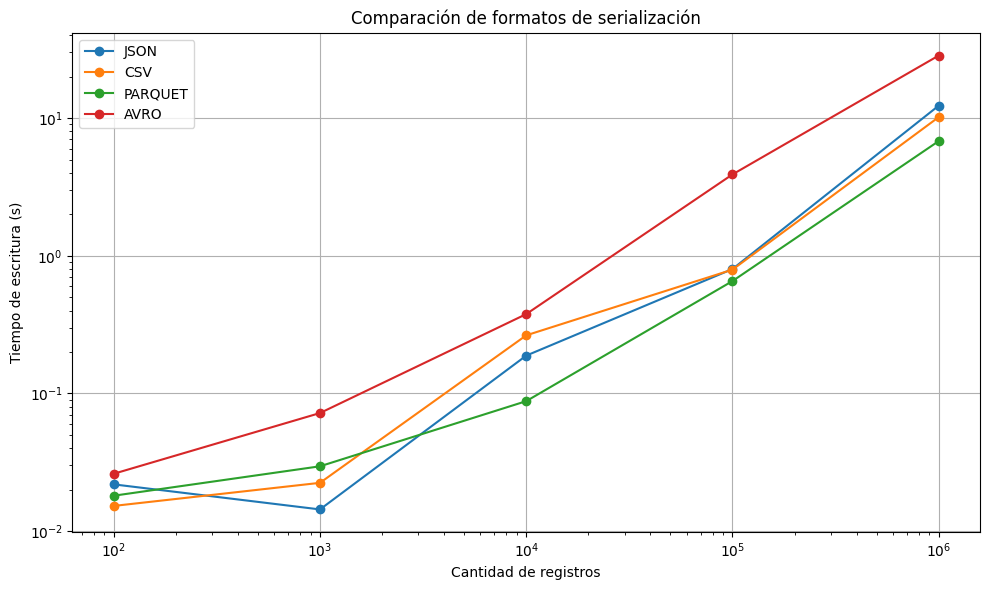

,ID_VENTA,FECHA_VENTA,ID_CLIENTE,ID_EMPLEADO,ID_PRODUCTO,CANTIDAD,PRECIO_UNITARIO,DESCUENTO,FORMA_PAGO
0,00004df7-75ba-4693-b8a8-e7157fca6b35,2024-08-09,5476,810,1178,13,666.58,20.75,Transfer
1,00006952-8e9e-4f4a-871b-0c8a905d837c,2024-08-10,942,730,1577,16,259.38,39.74,Check
2,00006a1a-5bfd-4491-aec3-1bff92e28a77,2024-06-30,7299,339,456,8,617.91,0.27,Transfer
3,00006cc9-bee2-4b74-b32b-7a4d4ae0f175,2024-09-29,997,252,1050,14,829.02,43.88,Check
4,00007785-74c5-4e49-910e-415b2f1d9ae6,2024-09-12,7284,265,1260,4,407.57,8.31,Cash
...,...,...,...,...,...,...,...,...,...
999995,ffffd59c-0469-48f4-87fb-4713de691b15,2024-09-17,576,923,3483,8,257.07,3.67,Card
999996,ffffe4be-eb41-4e34-af1f-3eb18df35f2b,2024-09-08,9213,887,7,9,730.24,20.73,Card
999997,ffffe92e-99ca-4483-af3c-6882b4dfff47,2024-11-23,5739,907,2283,4,972.92,9.89,Card
999998,fffff9ae-429d-4892-9338-02d93667858c,2024-07-25,5756,122,2721,6,575.94,41.30,Card


In [20]:
#Código para la extracción de datos de la base de datos
import pandas as pd
import time
import os
import json
import pyarrow as pa
import pyarrow.parquet as pq
from fastavro import writer, parse_schema
import matplotlib.pyplot as plt
import datetime
from decimal import Decimal


def get_connection():
    try:
        print("Connecting to the database...\n config: ", config)
        return connect(**config)
    except Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
        return None

def get_data(connection: connect, query: str):
    my_cursor = connection.cursor()
    my_cursor.execute(query)
    data = my_cursor.fetchall()
    my_cursor.close()
    return data


cnx = get_connection()

print("Connection established")

data = get_data(cnx, "SELECT * FROM UN.VENTAS")


df_full = pd.DataFrame(data, columns=['ID_VENTA', 'FECHA_VENTA', 'ID_CLIENTE', 'ID_EMPLEADO',
                  'ID_PRODUCTO', 'CANTIDAD', 'PRECIO_UNITARIO', 'DESCUENTO', 'FORMA_PAGO'])

cnx.close()


sizes = [100, 1_000, 10_000, 100_000, 1_000_000]
formats = ['json', 'csv', 'parquet', 'avro']
results = {fmt: [] for fmt in formats}

# Crear carpeta para los archivos si no existe
os.makedirs("output_files", exist_ok=True)

# Función para escribir en cada formato
def serialize_data(df, fmt, filename):
    start = time.time()
    path = os.path.join("output_files", filename)

    if fmt == 'json':
        df.to_json(path, orient='records', lines=True)

    elif fmt == 'csv':
        df.to_csv(path, index=False)

    elif fmt == 'parquet':
        table = pa.Table.from_pandas(df)
        pq.write_table(table, path)

    elif fmt == 'avro':
        df = df.copy()

        # 🔄 Convertimos fechas a string y decimales a float
        for col in df.columns:
            if df[col].apply(lambda x: isinstance(x, (datetime.date, datetime.datetime))).any():
                df[col] = df[col].astype(str)
            elif df[col].apply(lambda x: isinstance(x, Decimal)).any():
                df[col] = df[col].astype(float)

        records = df.to_dict(orient='records')

        # Inferencia de esquema Avro básico desde tipos de pandas
        avro_types = {
            'int64': 'long',
            'float64': 'double',
            'object': 'string',
            'bool': 'boolean'
        }

        schema = {
            "type": "record",
            "name": "Venta",
            "fields": []
        }

        for col in df.columns:
            dtype = str(df[col].dtype)
            avro_type = avro_types.get(dtype, 'string')  # default a string
            schema["fields"].append({
                "name": col,
                "type": ["null", avro_type],
                "default": None
            })

        with open(path, 'wb') as out:
            writer(out, parse_schema(schema), records)

    else:
        raise ValueError("Formato no soportado")

    return time.time() - start

# Medición de tiempos
for size in sizes:
    df_sample = df_full.head(size)
    print(f"\nTamaño: {size} registros")
    for fmt in formats:
        filename = f"{fmt}_{size}.{'avro' if fmt == 'avro' else fmt}"
        tiempo = serialize_data(df_sample, fmt, filename)
        print(f"{fmt.upper()}: {tiempo:.4f} s")
        results[fmt].append(tiempo)

# Graficar resultados
plt.figure(figsize=(10, 6))
for fmt in formats:
    plt.plot(sizes, results[fmt], marker='o', label=fmt.upper())

plt.xlabel("Cantidad de registros")
plt.ylabel("Tiempo de escritura (s)")
plt.title("Comparación de formatos de serialización")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df_full